In [3]:
import numpy as np
import numba as nb

#my library
from orderedTableSearch import locate_grid, locate_on_grids, locate

In [4]:
@nb.jit(nopython = True)
def fem_elmeval(x, x0, x1,para0, para1):
    diff = x1 - x0
    bs0 = (x1 - x)/diff
    bs1 = (x - x0)/diff
    #here I allow extrapolation
    #if bs0 >= 0.0 and bs1 >= 0.0:
    return para0*bs0 + para1*bs1
    #else:
    #    return 0.0
    
@nb.jit(nopython=True)
def fem_peval(xval, nodes, para):
    ie = locate(xval, nodes)
    return fem_elmeval(xval, nodes[ie], nodes[ie+1], para[ie], para[ie+1])    
    
@nb.jit(nopython = True)
def fem_grideval(xvals, nodes, para):
            
    N = len(nodes)
    M = len(xvals)
    if N != len(para):
        print('error: N != len(para)')
        return None


    #xelements = locate_grid(xvals, nodes)
    xelements = locate_on_grids(xvals, nodes)
    ans = np.zeros(M)
    for ix,x in enumerate(xvals):
        ie = xelements[ix]

        ans[ix] = fem_elmeval(x, nodes[ie], nodes[ie+1], para[ie], para[ie+1])

    return ans

#@nb.generated_jit(nopython=True)
#def femeval(xvals, nodes, para):
#    #I should prohibit extrapolation
#    if not hasattr(xvals, "__len__"): #if xvals is scalar
#        ie = locate_grid(xvals, nodes)
#        
#        return fem_elmeval(xvals, nodes[ie], nodes[ie+1], para[ie], para[ie+1])
#    else: #if xvals is actually array-like
#            
#        return fem_grideval(xvals, nodes, para)

@nb.generated_jit(nopython=True)
def femeval(xvals, nodes, para):

    if isinstance(xvals, nb.types.Float) or isinstance(xvals, nb.types.Integer):
        
        return lambda xvals, nodes, para: fem_peval(xvals, nodes, para)

    else: #if xvals is actually array-like
            
        return lambda xvals, nodes, para: fem_grideval(xvals, nodes, para)
    


In [14]:
def dy_femeval(x, xnodes):
    """
    
    
    """
    
    N = len(xnodes)
    
  
    ans = np.zeros(N)
    
    ie = locate(x, xnodes)
    
    #need to add some check
    x0 = xnodes[ie]
    x1 = xnodes[ie+1]
    diff = x1 - x0
    
    ans[ie] = (x1 - x)/diff
    ans[ie+1] = (x - x0)/diff
    
    return ans
    
    
    

 1.3502578735351562 seconds


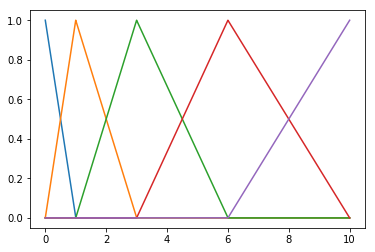

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("savefig",dpi=100)
from matplotlib import pyplot as plt

from scipy import linalg as LA
from scipy.optimize import fsolve
from numpy.polynomial.legendre import leggauss
#import numdifftools as nd

import time

#display options
np.set_printoptions(precision=3, linewidth = 120)

t1 = time.time()

xvals = np.linspace(0,10, 100000)
#nodes = [0,1,3,6,10]
nodes = [0, 1, 3, 6, 10]
plt.plot(xvals, femeval(xvals, nodes, [1, 0, 0, 0, 0]))
plt.plot(xvals, femeval(xvals, nodes, [0, 1, 0, 0, 0]))
plt.plot(xvals, femeval(xvals, nodes, [0, 0, 1, 0, 0]))
plt.plot(xvals, femeval(xvals, nodes, [0, 0, 0, 1, 0]))
plt.plot(xvals, femeval(xvals, nodes, [0, 0, 0, 0, 1]))

t2 = time.time()

print(' {} seconds'.format(t2 - t1))#most of the time are for plotting

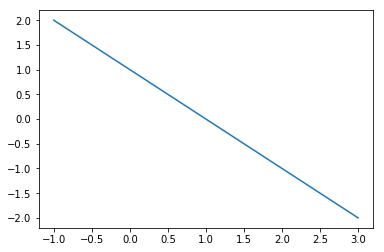

In [8]:
xvals = np.linspace(-1,3, 1000)
#nodes = [0,1,3,6,10]
nodes = [0, 1]
plt.plot(xvals, femeval(xvals, nodes, [1, 0]))
#plt.xlim([0,1])
#plt.ylim([0,1])

## Test code
Solve a differential problem
$$
d(x) + d^\prime(x) = 0
$$
with a boundary condition $d(0) = 1$

In [9]:
from numpy.polynomial.legendre import leggauss

#@nb.jit#(nopython = True)
def obj(nodes, para):
    
    #note: you cannot import leggauss inside the jit
    num_gl = 3
    glab, glwgt = leggauss(num_gl)
    
    N = len(nodes)
    if N != len(para):
        print('error:N!=len(para)')
        return None
    
    ans = np.zeros(N)

    for ie in range(N-1): #for each element

        x1, x2 = nodes[[ie, ie+1]]
        diff = (x2 - x1)

        absa = (glab+1)*diff/2 + x1
        wgt = diff/2*glwgt

        for ix, x in enumerate(absa): #for abscissa
        #for ix in range(len(absa)):
            x = absa[ix]
            bs1 = (x2 - x)/diff
            bs2 = (x - x1)/diff
            dbs1 = -1.0/diff
            dbs2 = 1.0/diff

            d = para[ie]*bs1 + para[ie+1]*bs2
            dd = para[ie]*dbs1 + para[ie+1]*dbs2

            res = d + dd
            ans[ie] = ans[ie] + res*wgt[ix]*bs1
            ans[ie+1] = ans[ie+1] + res*wgt[ix]*bs2
        
    return ans



In [10]:
nodes = np.array([0.0, 1.0, 3.0, 6.0])
t1 = time.time()
target = lambda x: obj(nodes, np.append([1], x))[1:]
para1 = np.append([1.], fsolve(target, [0.5, 0.5, 0.5]))
xvals = np.linspace(0.0, 6.0, 100)
approx = femeval(xvals, nodes, para1)

t2 = time.time()
print(' {} seconds'.format(t2 - t1))

 0.8160068988800049 seconds


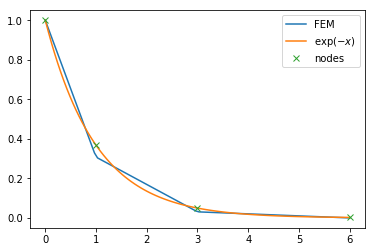

In [11]:
plt.plot(xvals, approx, label = 'FEM')
plt.plot(xvals, np.exp(-xvals), label = r'$\exp(-x)$')
plt.plot(nodes, np.exp(-nodes), 'x',label = 'nodes')
plt.legend(loc = 'best')

In [17]:
nodes

array([ 0.,  1.,  3.,  6.])

In [24]:
dy_femeval(7.0, nodes)

array([ 0.   ,  0.   , -0.333,  1.333])

In [12]:
femeval(xvals, nodes, para1)

array([  1.000e+00,   9.580e-01,   9.161e-01,   8.741e-01,   8.322e-01,   7.902e-01,   7.483e-01,   7.063e-01,
         6.643e-01,   6.224e-01,   5.804e-01,   5.385e-01,   4.965e-01,   4.545e-01,   4.126e-01,   3.706e-01,
         3.287e-01,   3.035e-01,   2.951e-01,   2.867e-01,   2.783e-01,   2.699e-01,   2.615e-01,   2.531e-01,
         2.448e-01,   2.364e-01,   2.280e-01,   2.196e-01,   2.112e-01,   2.028e-01,   1.944e-01,   1.860e-01,
         1.776e-01,   1.692e-01,   1.608e-01,   1.524e-01,   1.441e-01,   1.357e-01,   1.273e-01,   1.189e-01,
         1.105e-01,   1.021e-01,   9.371e-02,   8.531e-02,   7.692e-02,   6.853e-02,   6.014e-02,   5.175e-02,
         4.336e-02,   3.497e-02,   3.046e-02,   2.984e-02,   2.922e-02,   2.859e-02,   2.797e-02,   2.735e-02,
         2.673e-02,   2.611e-02,   2.549e-02,   2.486e-02,   2.424e-02,   2.362e-02,   2.300e-02,   2.238e-02,
         2.176e-02,   2.113e-02,   2.051e-02,   1.989e-02,   1.927e-02,   1.865e-02,   1.803e-02,   1.740e-02,
 